# Hybrid attack

### Load results 

In [2]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from IPython.display import display
from itertools import product
from Graph import Graph

# parameters 

sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")

# Deterministic attacks

In [3]:
from matplotlib.lines import Line2D


fig = plt.figure(figsize=(12, 15))
for i, result in enumerate(datasets):
    data = pd.read_csv(f'logs/deterministics/{result}.csv')
    data.columns = ['attack', 'run', 'prop', 'value']
    values = data.groupby(['attack', 'prop', 'run']).sum("value").reset_index()

    for _ in range(5):
        for attack in values["attack"].unique():
            values = pd.concat([values, pd.DataFrame({"attack": attack, "run": _, "prop": 1.0, "value": 0}, index=[0])])


    print(values.tail(10))

    values['attack'] = values['attack'].map({
        "completion": "Completion",
        "matching": "Matching",
        "triangle": "Triangle",
        "degree": "Degree",
        "rectangle": "Rectangle",
    })

    ax = fig.add_subplot(3, 2, i+1)   
    sns.lineplot(data=values, x="prop", y="value", hue='attack', marker="o", dashes=False, ax=ax, errorbar='sd', linewidth=4)
    ax.set_yscale('log')
    ax.set_title(result.upper(), fontdict={'fontsize': 20, 'fontweight': 'bold'})
    ax.set_xlabel(r"$\frac{|G_a|}{|G|}$", fontdict={'fontsize': 25})
    ax.set_ylabel("Number of modifications", fontdict={'fontsize': 18})
    ax.set_xlim(0, 1.1)
    # ax.legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=15)


    custom_lines = [
    Line2D([0], [0], color=sns.color_palette()[i], marker='o', markersize=4, label=attack) 
    for i, attack in enumerate(["Completion", "Degree", "Matching", "Rectangle", "Triangle"])
    ]
    fig.legend(
        handles=custom_lines,
        loc='lower center',
        fontsize=18,
        ncol=3,
        bbox_to_anchor=(0.52, 0.23)
    )


plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

# RAE -

In [ ]:
# datasets = ['polblogs', 'cora']
grapn1_props = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
fig = plt.figure(figsize=(12, 15))
for i, result in enumerate(datasets):
    data = pd.read_csv(f"logs/benchmark/{result}.csv")
    data.columns = ["expe","attack_type","optim","alpha","beta","gamma","graph1_prop","common_prop","iter_number","impossible_edges","reconstructed_edges","unknown_edges","TP","FP","TN","FN","time"]

    data =  data[data['graph1_prop'].isin(grapn1_props) & (data['attack_type'] == 'D')]
    
    data["RAE_minus"] = data["unknown_edges"] / (data["TP"] + data["FN"])
    
    ax = fig.add_subplot(3, 2, i+1)   
    sns.lineplot(data=data, x="graph1_prop", y="RAE_minus", ax=ax)
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$\frac{|G_a|}{|G|}$", fontdict={'fontsize': 25})
    ax.set_ylabel(r"$RAE^-$")
    ax.set_yscale("log")
    ax.set_title(result.upper(), fontdict={'fontsize': 20, 'fontweight': 'bold'})
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()
    


# RAE-G1 empty

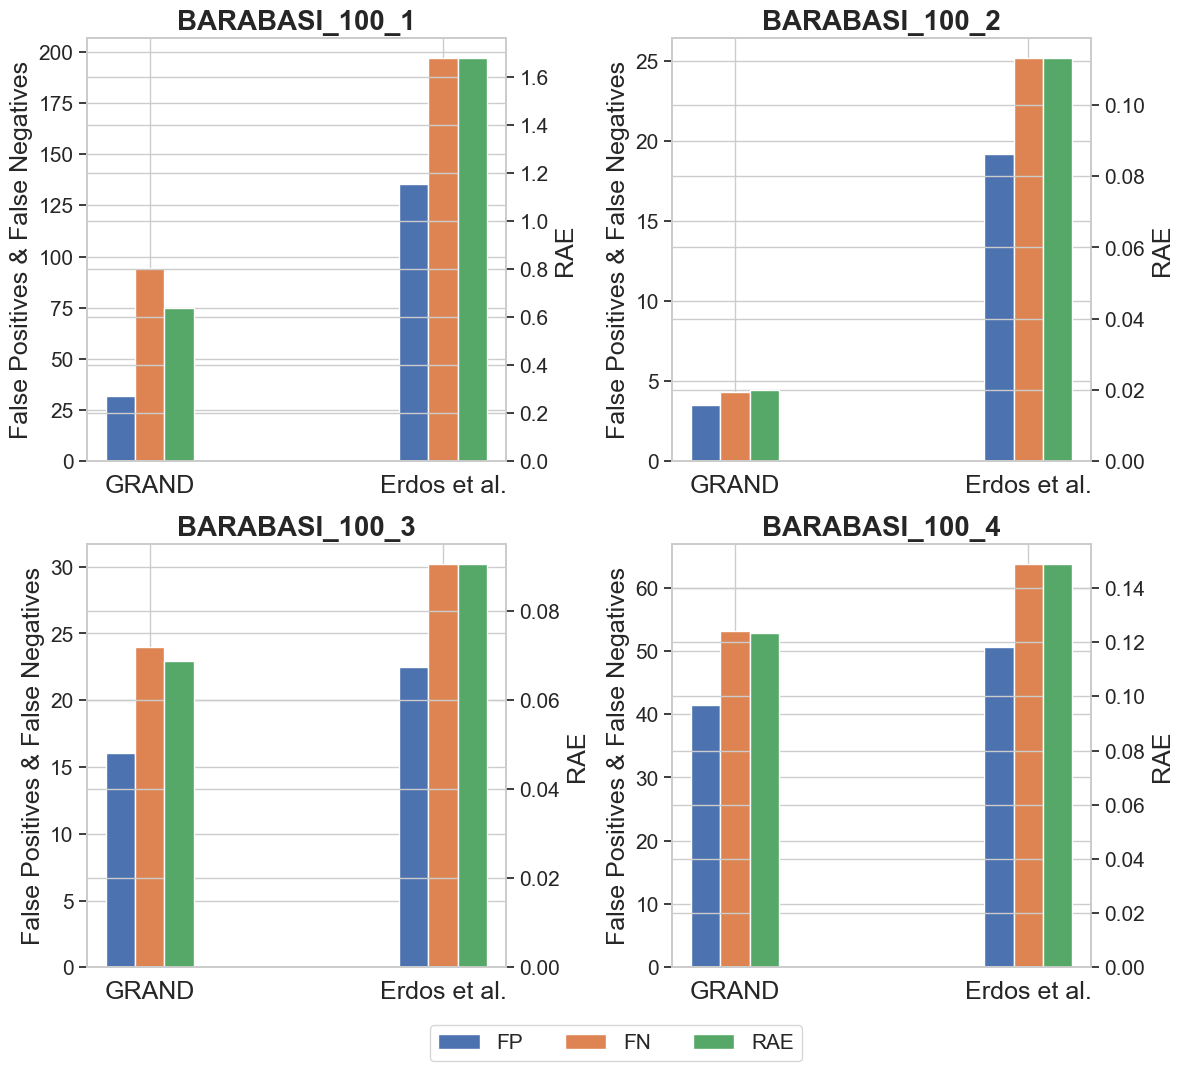

In [17]:
datasets = ['barabasi_100_1','barabasi_100_2','barabasi_100_3','barabasi_100_4']

fig = plt.figure(figsize=(12, 15))
colors = color=sns.color_palette()
for i, result in enumerate(datasets):
    data = pd.read_csv(f"logs/benchmark/{result}.csv")
    data.columns = ["expe","attack_type","optim","alpha","beta","gamma","graph1_prop","common_prop","iter_number","impossible_edges","reconstructed_edges","unknown_edges","TP","FP","TN","FN","time"]

    data = data[(data["graph1_prop"] == 0) & ((data["attack_type"] == "H") | ( ( data["attack_type"].str.startswith("DDH")) & (data["optim"] == 0) & (data["alpha"] == 0.0) & (data["beta"] == 0.0) & (data["gamma"] == 0)))]
    data = data.groupby(["attack_type"]).mean(["FP", "TP", "FN", "TN"]).reset_index()

    data.loc[:, "RAE"] = (data["FP"] + data["FN"]) / (data["TP"] + data["FN"])
    data["beta"] = data["beta"].replace(0, "|E*|/n^2")
    data["alpha"] = data["alpha"].replace(0, "1-beta")
    data["attack_type"] = data["attack_type"].replace("H", "Erdos et al.")
    data["attack_type"] = data["attack_type"].replace("DDH.*", "GRAND", regex=True)

    ax = fig.add_subplot(3, 2, i+1)   
    ax2 = ax.twinx()
    
    x = np.arange(len(data))
    width = 0.1
    ax.bar(x - width, data["FP"], width, label="FP", color=colors[0])
    ax.bar(x, data["FN"], width, label="FN", color=colors[1])
    ax2.bar(x + width, data["RAE"], width, label="RAE", color=colors[2])

    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(data["attack_type"], rotation=0, fontsize=18)
    ax.set_title(result.upper(), fontdict={'fontsize': 20, 'fontweight': 'bold'})
    ax2.set_ylabel("RAE", fontsize=18)
    ax.set_ylabel("False Positives & False Negatives", fontsize=18)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax2.tick_params(axis='y', which='major', labelsize=15)

plt.tight_layout()
# plt.legend in the bottom right corner. Add custom colors and labels
fig.legend(["FP", "FN", "RAE"], loc='lower center', fontsize=15, ncol=3, bbox_to_anchor=(0.52, 0.28))
plt.show()


    

      expe   attack_type  optim  alpha  beta  gamma  graph1_prop  common_prop  \
0        0  Erdos et al.      0    0.0   0.0    0.0         0.00            0   
3        0  Erdos et al.      1    0.0   0.0    0.0         0.05            0   
6        0  Erdos et al.      1    0.0   0.0    0.0         0.10            0   
9        0  Erdos et al.      1    0.0   0.0    0.0         0.20            0   
12       0  Erdos et al.      1    0.0   0.0    0.0         0.30            0   
...    ...           ...    ...    ...   ...    ...          ...          ...   
3294    99  Erdos et al.      1    0.0   0.0    0.0         0.80            0   
3297    99  Erdos et al.      1    0.0   0.0    0.0         0.90            0   
3300     0  Erdos et al.      0    0.0   0.0    0.0         0.00            0   
3303     0  Erdos et al.      1    0.0   0.0    0.0         0.05            0   
3306     0  Erdos et al.      1    0.0   0.0    0.0         0.10            0   

      iter_number  impossib

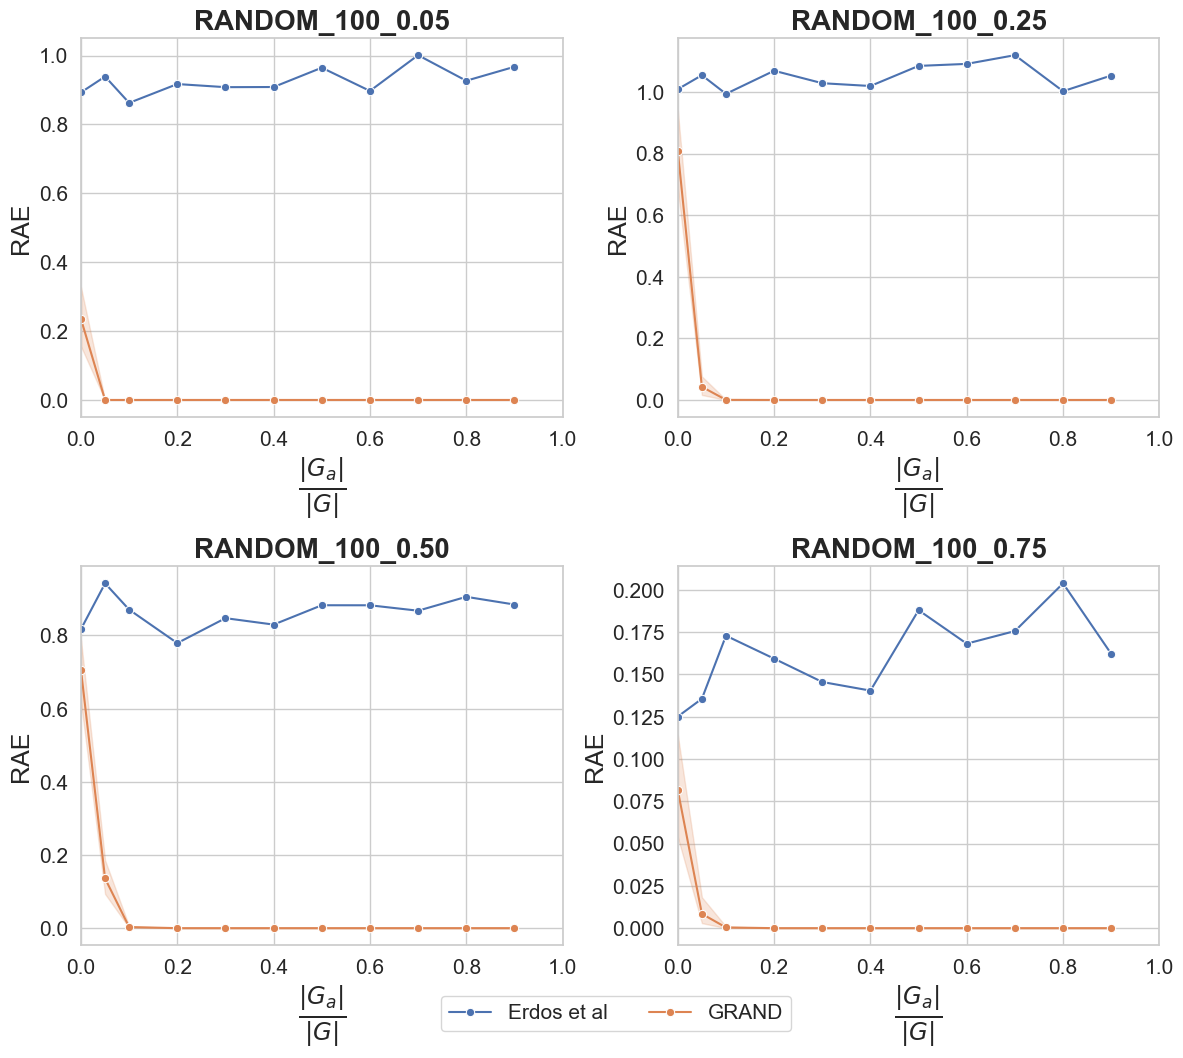

In [ ]:
# datasets = ['barabasi_100_4']
# datasets = ['barabasi_100_1','barabasi_100_2','barabasi_100_3','barabasi_100_4']
datasets = ['random_100_0.05','random_100_0.25','random_100_0.50', 'random_100_0.75']
# datasets = ['random_500_0.05','random_500_0.25', 'random_500_0.50', 'random_500_0.75']

colors = color=sns.color_palette()

fig = plt.figure(figsize=(12, 15))

for i, result in enumerate(datasets):
    data = pd.read_csv(f"logs/benchmark/{result}.csv")

    data.columns = ["expe","attack_type","optim","alpha","beta","gamma","graph1_prop","common_prop","iter_number","impossible_edges","reconstructed_edges","unknown_edges","TP","FP","TN","FN","time"]

    data = data[((data["attack_type"] == "H") | ( ( data["attack_type"].str.startswith("DDH")) & (data["optim"] == True) & (data["alpha"] == 0) & (data["beta"] == 0) & (data["gamma"] == 0)))]

    
    data["attack_type"] = data["attack_type"].replace("H", "Erdos et al.")
    data["attack_type"] = data["attack_type"].replace("DDH.*", "GRAND", regex=True)

    
    data.loc[:, "RAE"] = (data["FP"] + data["FN"]) / (data["TP"] + data["FN"])
    ours = data[data["attack_type"] == "GRAND"]
    erdos_et_al = data[data["attack_type"] == "Erdos et al."]

    props = data["graph1_prop"].unique()
    props = np.append(props, 1)

    ax = fig.add_subplot(3, 2, i+1)  

    print(erdos_et_al)
    line1 = sns.lineplot(data=erdos_et_al, x="graph1_prop", y="RAE", ax=ax, color=colors[0], marker='o', errorbar=None)
    line2 = sns.lineplot(data=ours, x='graph1_prop', y='RAE', ax=ax, color=colors[1], marker='o')
    ax.set_title(result.upper(), fontdict={'fontsize': 20, 'fontweight': 'bold'})
    ax.set_xlabel(r"$\frac{|G_a|}{|G|}$", fontsize=25)
    ax.set_ylabel("RAE", fontsize=18)
    # ax.set_ylim(0, max(ours["RAE"].max(), erdos_et_al["RAE"].max()) + 0.01)
    ax.set_xlim(0, 1)
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout() 
fig.legend(["Erdos et al", "GRAND"], loc='lower center', fontsize=15, ncol=3, bbox_to_anchor=(0.52, 0.3))
plt.show()
  

    